In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType
from pyspark.sql.types import StructField
from pyspark.sql.types import StringType
import os
os.environ["PYSPARK_PYTHON"]="/usr/bin/python3.5"

spark = SparkSession.builder \
    .master("yarn") \
    .appName("adult_logReg_preparation") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

sc = spark.sparkContext
'''
#在定义字段名的同时也定义了数据类型，所以对于混合数据类型，不能采用批量定义的方法
row_name = "age, workclass, fnlwgt, education, education-num, marital-status, occupation, relationship, race, sex, capital-gain, capital-loss, hours-per-week, native-country, income"
#根据模式字符串生成模式
fields = list(map(lambda fieldName : StructField(fieldName, StringType(), nullable = True), row_name.split(", ")))
schema = StructType(fields)
df = spark.read.csv('hdfs://master:9000/dataset/adult.csv', schema=schema, inferSchema=True, header=True)
'''
df = spark.read.csv('hdfs://master:9000/dataset/adult.csv', inferSchema=True, header=True)
df.show(3)

+---+-----------------+------+----------+-------------+-------------------+------------------+--------------+------+-----+------------+------------+--------------+--------------+------+
|age|        workclass|fnlwgt| education|education-num|     marital-status|        occupation|  relationship|  race|  sex|capital-gain|capital-loss|hours-per-week|native-country|income|
+---+-----------------+------+----------+-------------+-------------------+------------------+--------------+------+-----+------------+------------+--------------+--------------+------+
| 39|        State-gov| 77516| Bachelors|           13|      Never-married|      Adm-clerical| Not-in-family| White| Male|        2174|           0|            40| United-States| <=50K|
| 50| Self-emp-not-inc| 83311| Bachelors|           13| Married-civ-spouse|   Exec-managerial|       Husband| White| Male|           0|           0|            13| United-States| <=50K|
| 38|          Private|215646|   HS-grad|            9|           Divo

In [4]:
print(df.count())
df.printSchema()

32561
root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- education-num: integer (nullable = true)
 |-- marital-status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital-gain: integer (nullable = true)
 |-- capital-loss: integer (nullable = true)
 |-- hours-per-week: integer (nullable = true)
 |-- native-country: string (nullable = true)
 |-- income: string (nullable = true)



### 1. workclass  
**有限责任公司（Self-emp-inc）,无限责任公司（Self-emp-not-inc）,个人（Private）,联邦政府（Federal-gov）,州政府（State-gov）地方政府（ Local-gov）,无工作经验人员（Never-worked）,无薪人员（Without-pay）**  
work_class = { 'Self-emp-inc': 1.0, 'Self-emp-not-inc': 2.0, 'Private': 3.0, 'Federal-gov': 4.0, 'State-gov': 5.0, 'Local-gov': 6.0, 'Never-worked': 7.0, 'Without-pay': 8.0, '?': 0.0} 
### 2. education  
**教育情况：Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool**  
education = {'Bachelors': 1.0, 'Some-college': 2.0, '11th': 3.0, 'HS-grad': 4.0, 'Prof-school': 5.0, 'Assoc-acdm': 6.0, 'Assoc-voc': 7.0, '9th': 8.0, '7th-8th': 9.0, '12th': 10.0, 'Masters': 11.0, '1st-4th': 12.0, '10th': 13.0, 'Doctorate': 14.0, '5th-6th': 15.0, 'Preschool': 16.0}
### 3. marital-status  
**已婚（Married-civ-spouse），再婚（Married-AF-spouse）,已婚配偶缺席（Married-spouse-absent）,离婚（Divorced） # 离异（Separated），丧偶（Widowed）,未婚（Never-married）**  
marital_status = {'Married-civ-spouse': 1.0, 'Married-AF-spouse': 2.0, 'Married-spouse-absent': 3.0, 'Divorced': 4.0, 'Separated': 5.0, 'Widowed': 6.0, 'Never-married': 7.0}
### 4. occupation  
**职业（Occupation）：清洁工（Handlers-cleaners），维修工艺（Craft-repair），服务行业（Other-service）， 销售（Sales），机床操控人员（Machine-op-inspct）， 执行管理（Exec-managerial）， 专业教授（Prof-specialty），技术支持（Tech-support），行政文员（Adm-clerical），养殖渔业（Farming-fishing）， 运输行业（Transport-moving），私人房屋服务（Priv-house-serv）， 保卫工作（Protective-serv）， 武装部队（Armed-Forces）**  
occupation = {'Handlers-cleaners': 1.0, 'Craft-repair': 2.0, 'Other-service': 3.0, 'Sales': 4.0, 'Machine-op-inspct': 5.0, 'Exec-managerial': 6.0, 'Prof-specialty': 7.0, 'Tech-support': 8.0, 'Adm-clerical': 9.0, 'Farming-fishing': 10.0, 'Transport-moving': 11.0, 'Priv-house-serv': 12.0, 'Protective-serv': 13.0, 'Armed-Forces': 14.0, '?': 0.0}
### 5. relationship  
**妻子（Wife），子女（Own-child），丈夫（Husband），外来人员（Not-in-family）、 其他亲戚（Other-relative）、 未婚（Unmarried）**  
relationship = {'Wife': 1.0, 'Husband': 2.0, 'Own-child': 3.0, 'Unmarried': 4.0, 'Other-relative': 5.0, 'Not-in-family': 6.0}
### 6. race  
**白人（White），亚洲太平洋岛民（Asian-Pac-Islander），阿米尔-印度-爱斯基摩人（Amer-Indian-Eskimo）、 其他（Other），黑人（Black）**  
race = {'White': 1.0, 'Black': 2.0, 'Asian-Pac-Islander': 3.0, 'Amer-Indian-Eskimo': 4.0, 'Other': 5.0} sex = {'Female': 1.0, 'Male': 2.0}
### 7. native-country  
**美国（United-States）、 柬埔寨（Cambodia）、 英国（England），波多黎各（Puerto-Rico），加拿大（Canada），德国（Germany）, 美国周边地区（关岛-美属维尔京群岛等）（Outlying-US(Guam-USVI-etc)）， 印度（India）、 日本（Japan）、 希腊（Greece）,美国南部（South）、 中国（China）、 古巴（Cuba）、 伊朗（Iran）、 洪都拉斯（Honduras），菲律宾（Philippines） # 意大利（Italy）、 波兰（Poland）、 牙买加（Jamaica）、 越南（Vietnam）、 墨西哥（Mexico）、 葡萄牙（Portugal）,爱尔兰（Ireland）、 法国（France）、多米尼加共和国（Dominican-Republic）、 老挝（Laos）、 厄瓜多尔（Ecuador） # 台湾（Taiwan）、 海地（Haiti）、 哥伦比亚（Columbia）、 匈牙利（Hungary）、 危地马拉（Guatemala）、 尼加拉瓜（Nicaragua）, 苏格兰（Scotland）、 泰国（Thailand）、 南斯拉夫（Yugoslavia），萨尔瓦多（El-Salvador）、 特立尼达和多巴哥（Trinadad&Tobago）, 秘鲁（Peru），香港（Hong），荷兰（Holland-Netherlands）**   
Nation_country = {'United-States': 1.0, 'Cambodia': 2.0, 'England': 3.0, 'Puerto-Rico': 4.0, 'Canada': 5.0, 'Germany': 6.0, 'Outlying-US(Guam-USVI-etc)': 7.0, 'India': 8.0, 'Japan': 9.0, 'Greece': 10.0, 'South': 11.0, 'China': 12.0, 'Cuba': 13.0, 'Iran': 14.0, 'Honduras': 15.0, 'Philippines': 16.0, 'Italy': 17.0, 'Poland': 18.0, 'Jamaica': 19.0, 'Vietnam': 20.0, 'Mexico': 21.0, 'Portugal': 22.0, 'Ireland': 23.0, 'France': 24.0, 'Dominican-Republic': 25.0, 'Laos': 26.0, 'Ecuador': 27.0, 'Taiwan': 28.0, 'Haiti': 29.0, 'Columbia': 30.0, 'Hungary': 31.0, 'Guatemala': 32.0, 'Nicaragua': 33.0, 'Scotland': 34.0, 'Thailand': 35.0, 'Yugoslavia': 36.0, 'El-Salvador': 37.0, 'Trinadad&Tobago': 38.0, 'Peru': 39.0, 'Hong': 40.0, 'Holand-Netherlands': 41.0, '?': 0.0} 
### 8. income  
income = {'>50K': 1.0, '<=50K': 0.0} 

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
age,39,50,38,53,28
workclass,State-gov,Self-emp-not-inc,Private,Private,Private
fnlwgt,77516,83311,215646,234721,338409
education,Bachelors,Bachelors,HS-grad,11th,Bachelors
education-num,13,13,9,7,13
marital-status,Never-married,Married-civ-spouse,Divorced,Married-civ-spouse,Married-civ-spouse
occupation,Adm-clerical,Exec-managerial,Handlers-cleaners,Handlers-cleaners,Prof-specialty
relationship,Not-in-family,Husband,Not-in-family,Husband,Wife
race,White,White,White,Black,Black
sex,Male,Male,Male,Male,Female


In [7]:
df.groupby('race').count().toPandas()

,race,count
0,Asian-Pac-Islander,1039
1,Black,3124
2,Other,271
3,White,27816
4,Amer-Indian-Eskimo,311


In [6]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,32561,38.58164675532078,13.640432553581356,17,90
fnlwgt,32561,189778.36651208502,105549.97769702227,12285,1484705
education-num,32561,10.0806793403151,2.572720332067397,1,16
capital-gain,32561,1077.6488437087312,7385.292084840354,0,99999
capital-loss,32561,87.303829734959,402.960218649002,0,4356
hours-per-week,32561,40.437455852092995,12.347428681731838,1,99


## 查看各个特征之间的相关性
### 利用pd.scatter_matrix需要import matplotlib.pyplot as plt

/home/hadoop/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  app.launch_new_instance()


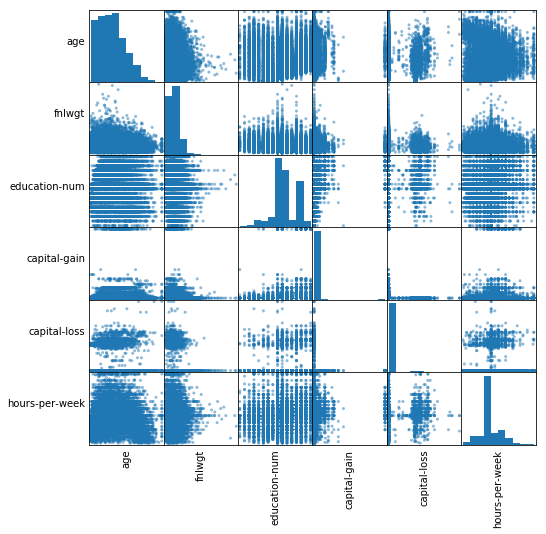

In [12]:
numeric_data = df.select(numeric_features).toPandas()

axs = pd.scatter_matrix(numeric_data, figsize=(8, 8))

n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())